# Investment Insights and Portfolio Strategies

This notebook generates actionable insights from the cryptocurrency clustering analysis, including investment recommendations, risk assessments, and portfolio diversification strategies.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Clustering Results and Data

In [14]:
# Load clustered cryptocurrencies
clustered_coins = pd.read_csv('../reports/clustered_cryptocurrencies.csv', index_col=0)

# Load cluster summary statistics
cluster_summary = pd.read_csv('../reports/cluster_summary_statistics.csv')

# Load clustering metadata
with open('../reports/clustering_metadata.json', 'r') as f:
    clustering_metadata = json.load(f)

print(f"Loaded {len(clustered_coins)} cryptocurrencies across {clustering_metadata['n_clusters']} clusters")
print(f"\nCluster distribution:")
print(clustered_coins['kmeans_cluster'].value_counts().sort_index())

Loaded 1383 cryptocurrencies across 5 clusters

Cluster distribution:
kmeans_cluster
0    1378
1       1
2       1
3       1
4       2
Name: count, dtype: int64


## 2. Risk Assessment Framework

In [15]:
# Define risk categories based on volatility and drawdown
def categorize_risk(row):
    volatility = row['volatility']
    
    if volatility < 0.03:
        return 'Low Risk'
    elif volatility < 0.05:
        return 'Medium Risk'
    elif volatility < 0.08:
        return 'High Risk'
    else:
        return 'Very High Risk'

# Add risk categories
clustered_coins['risk_category'] = clustered_coins.apply(categorize_risk, axis=1)

# Calculate risk scores (0-100)
# Normalize volatility to 0-100 scale
max_volatility = clustered_coins['volatility'].max()
min_volatility = clustered_coins['volatility'].min()
clustered_coins['risk_score'] = ((clustered_coins['volatility'] - min_volatility) / 
                                 (max_volatility - min_volatility) * 100)

# Risk assessment by cluster
risk_by_cluster = clustered_coins.groupby('kmeans_cluster').agg({
    'risk_score': ['mean', 'std'],
    'risk_category': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
})

print("Risk Assessment by Cluster:")
print(risk_by_cluster)

Risk Assessment by Cluster:
                risk_score              risk_category
                      mean        std        <lambda>
kmeans_cluster                                       
0                 0.018910   0.109760  Very High Risk
1                 0.044707        NaN  Very High Risk
2                42.163524        NaN  Very High Risk
3               100.000000        NaN  Very High Risk
4                32.367015  12.374893  Very High Risk


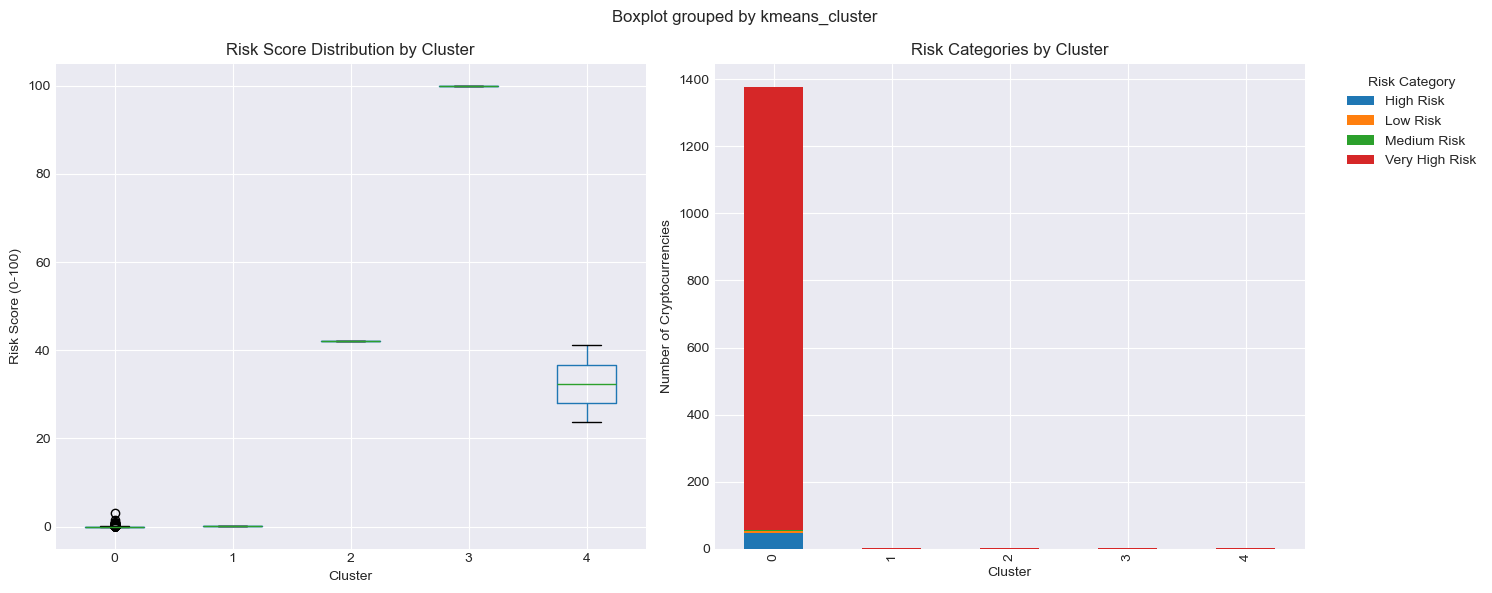

In [16]:
# Visualize risk distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Risk score distribution by cluster
clustered_coins.boxplot(column='risk_score', by='kmeans_cluster', ax=ax1)
ax1.set_title('Risk Score Distribution by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Risk Score (0-100)')

# Risk categories by cluster
risk_category_counts = clustered_coins.groupby(['kmeans_cluster', 'risk_category']).size().unstack(fill_value=0)
risk_category_counts.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Risk Categories by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Cryptocurrencies')
ax2.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 3. Investment Recommendations by Investor Profile

In [17]:
# Define investor profiles
investor_profiles = {
    'Conservative': {
        'description': 'Risk-averse investors seeking stable returns',
        'risk_tolerance': 'Low',
        'preferred_volatility': (0, 0.03),
        'btc_correlation_preference': (0.7, 1.0),
        'allocation_strategy': 'Focus on established coins with high market cap'
    },
    'Moderate': {
        'description': 'Balanced investors seeking growth with controlled risk',
        'risk_tolerance': 'Medium',
        'preferred_volatility': (0.02, 0.05),
        'btc_correlation_preference': (0.4, 0.8),
        'allocation_strategy': 'Mix of stable and growth-oriented coins'
    },
    'Aggressive': {
        'description': 'Risk-tolerant investors seeking high returns',
        'risk_tolerance': 'High',
        'preferred_volatility': (0.04, 0.10),
        'btc_correlation_preference': (0, 0.6),
        'allocation_strategy': 'Focus on high-growth potential altcoins'
    },
    'Speculative': {
        'description': 'Very high risk tolerance, seeking explosive growth',
        'risk_tolerance': 'Very High',
        'preferred_volatility': (0.06, 1.0),
        'btc_correlation_preference': (-1, 0.5),
        'allocation_strategy': 'High-risk, high-reward coins with low correlation to Bitcoin'
    }
}

# Generate recommendations for each investor profile
recommendations = {}

for profile_name, profile in investor_profiles.items():
    # Filter coins based on profile preferences
    vol_min, vol_max = profile['preferred_volatility']
    corr_min, corr_max = profile['btc_correlation_preference']
    
    suitable_coins = clustered_coins[
        (clustered_coins['volatility'] >= vol_min) & 
        (clustered_coins['volatility'] <= vol_max) &
        (clustered_coins['btc_correlation'] >= corr_min) & 
        (clustered_coins['btc_correlation'] <= corr_max)
    ]
    
    # Get top recommendations
    if profile_name in ['Conservative', 'Moderate']:
        # Sort by market cap for conservative investors
        top_coins = suitable_coins.nlargest(10, 'avg_market_cap')
    else:
        # Sort by return/volatility ratio for aggressive investors
        suitable_coins['return_volatility_ratio'] = suitable_coins['avg_daily_return'] / suitable_coins['volatility']
        top_coins = suitable_coins.nlargest(10, 'return_volatility_ratio')
    
    recommendations[profile_name] = {
        'profile': profile,
        'suitable_coins_count': len(suitable_coins),
        'top_recommendations': top_coins[['name', 'symbol', 'kmeans_cluster', 'avg_daily_return', 
                                         'volatility', 'btc_correlation', 'risk_category']].to_dict('records')
    }

# Display recommendations
for profile_name, rec in recommendations.items():
    print(f"\n{'='*60}")
    print(f"PROFILE: {profile_name}")
    print(f"Description: {rec['profile']['description']}")
    print(f"Suitable coins found: {rec['suitable_coins_count']}")
    print(f"\nTop 5 Recommendations:")
    for i, coin in enumerate(rec['top_recommendations'][:5]):
        print(f"{i+1}. {coin['name']} ({coin['symbol']}) - Cluster {coin['kmeans_cluster']}")
        print(f"   Return: {coin['avg_daily_return']:.4f}, Volatility: {coin['volatility']:.4f}")
        print(f"   BTC Correlation: {coin['btc_correlation']:.3f}, Risk: {coin['risk_category']}")


PROFILE: Conservative
Description: Risk-averse investors seeking stable returns
Suitable coins found: 0

Top 5 Recommendations:

PROFILE: Moderate
Description: Balanced investors seeking growth with controlled risk
Suitable coins found: 1

Top 5 Recommendations:
1. Colu Local Network (CLN) - Cluster 0
   Return: -0.0092, Volatility: 0.0464
   BTC Correlation: 0.693, Risk: Medium Risk

PROFILE: Aggressive
Description: Risk-tolerant investors seeking high returns
Suitable coins found: 206

Top 5 Recommendations:
1. Stratis (STRAT) - Cluster 0
   Return: 0.0097, Volatility: 0.0998
   BTC Correlation: 0.445, Risk: Very High Risk
2. Ethereum (ETH) - Cluster 0
   Return: 0.0060, Volatility: 0.0740
   BTC Correlation: 0.363, Risk: High Risk
3. Karbo (KRB) - Cluster 0
   Return: 0.0076, Volatility: 0.0987
   BTC Correlation: 0.339, Risk: Very High Risk
4. Decred (DCR) - Cluster 0
   Return: 0.0066, Volatility: 0.0885
   BTC Correlation: 0.358, Risk: Very High Risk
5. Golem (GNT) - Cluster 0
 

## 4. Portfolio Diversification Strategies

In [18]:
# Define diversification strategies
diversification_strategies = {
    'Cluster-Based Diversification': {
        'description': 'Allocate across different behavioral clusters to reduce concentration risk',
        'approach': 'Equal or weighted allocation across clusters',
        'benefits': ['Exposure to different market behaviors', 'Reduced correlation risk', 'Balanced risk-return profile']
    },
    'Risk-Tiered Portfolio': {
        'description': 'Pyramid allocation with majority in low-risk assets',
        'approach': '50% Low Risk, 30% Medium Risk, 15% High Risk, 5% Very High Risk',
        'benefits': ['Controlled risk exposure', 'Stable base with growth potential', 'Suitable for most investors']
    },
    'Core-Satellite Strategy': {
        'description': 'Core holdings in established coins with satellite positions in high-growth potential',
        'approach': '70% in top market cap coins, 30% in selected altcoins',
        'benefits': ['Stability from core holdings', 'Growth from satellites', 'Flexible rebalancing']
    },
    'Bitcoin-Correlation Based': {
        'description': 'Diversify based on correlation with Bitcoin',
        'approach': 'Mix high, medium, and low correlation coins',
        'benefits': ['Hedge against Bitcoin volatility', 'Capture independent movements', 'True diversification']
    }
}

# Generate sample portfolios for each strategy
sample_portfolios = {}

# 1. Cluster-Based Portfolio
cluster_allocation = {}
for cluster in range(clustering_metadata['n_clusters']):
    cluster_coins = clustered_coins[clustered_coins['kmeans_cluster'] == cluster]
    # Select top 2 coins from each cluster by market cap
    top_cluster_coins = cluster_coins.nlargest(2, 'avg_market_cap')
    cluster_allocation[f'Cluster_{cluster}'] = {
        'allocation': f"{100/clustering_metadata['n_clusters']:.1f}%",
        'coins': top_cluster_coins[['name', 'symbol']].to_dict('records')
    }

sample_portfolios['Cluster-Based'] = cluster_allocation

# 2. Risk-Tiered Portfolio
risk_allocation = {}
risk_tiers = {'Low Risk': 0.5, 'Medium Risk': 0.3, 'High Risk': 0.15, 'Very High Risk': 0.05}
for risk_cat, allocation in risk_tiers.items():
    risk_coins = clustered_coins[clustered_coins['risk_category'] == risk_cat]
    if len(risk_coins) > 0:
        top_risk_coins = risk_coins.nlargest(3, 'avg_market_cap')
        risk_allocation[risk_cat] = {
            'allocation': f"{allocation*100:.0f}%",
            'coins': top_risk_coins[['name', 'symbol']].to_dict('records')
        }

sample_portfolios['Risk-Tiered'] = risk_allocation

# Display portfolio strategies
print("PORTFOLIO DIVERSIFICATION STRATEGIES")
print("=" * 80)

for strategy_name, strategy in diversification_strategies.items():
    print(f"\n{strategy_name}:")
    print(f"Description: {strategy['description']}")
    print(f"Approach: {strategy['approach']}")
    print(f"Benefits:")
    for benefit in strategy['benefits']:
        print(f"  - {benefit}")

PORTFOLIO DIVERSIFICATION STRATEGIES

Cluster-Based Diversification:
Description: Allocate across different behavioral clusters to reduce concentration risk
Approach: Equal or weighted allocation across clusters
Benefits:
  - Exposure to different market behaviors
  - Reduced correlation risk
  - Balanced risk-return profile

Risk-Tiered Portfolio:
Description: Pyramid allocation with majority in low-risk assets
Approach: 50% Low Risk, 30% Medium Risk, 15% High Risk, 5% Very High Risk
Benefits:
  - Controlled risk exposure
  - Stable base with growth potential
  - Suitable for most investors

Core-Satellite Strategy:
Description: Core holdings in established coins with satellite positions in high-growth potential
Approach: 70% in top market cap coins, 30% in selected altcoins
Benefits:
  - Stability from core holdings
  - Growth from satellites
  - Flexible rebalancing

Bitcoin-Correlation Based:
Description: Diversify based on correlation with Bitcoin
Approach: Mix high, medium, and l

In [19]:
# Create portfolio performance comparison
def calculate_portfolio_metrics(coins_df, weights=None):
    """Calculate portfolio metrics based on historical performance"""
    if weights is None:
        weights = np.ones(len(coins_df)) / len(coins_df)
    
    # Portfolio return
    portfolio_return = np.sum(coins_df['avg_daily_return'] * weights)
    
    # Portfolio volatility (simplified - assuming some correlation)
    portfolio_volatility = np.sqrt(np.sum((coins_df['volatility'] * weights) ** 2))
    
    # Sharpe ratio
    sharpe = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else 0
    
    return {
        'expected_daily_return': portfolio_return,
        'expected_annual_return': portfolio_return * 365,
        'volatility': portfolio_volatility,
        'sharpe_ratio': sharpe
    }

# Compare different portfolio strategies
portfolio_comparisons = []

# Equal weight portfolio (baseline)
top_20_coins = clustered_coins.nlargest(20, 'avg_market_cap')
equal_weight_metrics = calculate_portfolio_metrics(top_20_coins)
portfolio_comparisons.append({
    'Strategy': 'Equal Weight Top 20',
    **equal_weight_metrics
})

# Market cap weighted
market_cap_weights = top_20_coins['avg_market_cap'] / top_20_coins['avg_market_cap'].sum()
market_cap_metrics = calculate_portfolio_metrics(top_20_coins, market_cap_weights)
portfolio_comparisons.append({
    'Strategy': 'Market Cap Weighted',
    **market_cap_metrics
})

# Low risk focused
low_risk_coins = clustered_coins[clustered_coins['risk_category'] == 'Low Risk'].nlargest(10, 'avg_market_cap')
if len(low_risk_coins) > 0:
    low_risk_metrics = calculate_portfolio_metrics(low_risk_coins)
    portfolio_comparisons.append({
        'Strategy': 'Low Risk Focus',
        **low_risk_metrics
    })

# Create comparison dataframe
portfolio_comparison_df = pd.DataFrame(portfolio_comparisons)
print("\nPortfolio Strategy Performance Comparison:")
print(portfolio_comparison_df.round(4))


Portfolio Strategy Performance Comparison:
              Strategy  expected_daily_return  expected_annual_return   
0  Equal Weight Top 20                 0.0059                  2.1562  \
1  Market Cap Weighted                 0.0045                  1.6362   
2       Low Risk Focus                 0.0001                  0.0345   

   volatility  sharpe_ratio  
0      0.0230        0.2565  
1      0.0269        0.1666  
2      0.0079        0.0119  


## 5. Market Condition Recommendations

In [20]:
# Define market condition strategies
market_conditions = {
    'Bull Market': {
        'description': 'Rising market with positive sentiment',
        'recommended_clusters': [],
        'strategy': 'Increase exposure to high-growth, volatile altcoins',
        'allocation_shift': 'Move 20% from stable to growth coins',
        'risk_management': 'Set trailing stop losses to protect gains'
    },
    'Bear Market': {
        'description': 'Declining market with negative sentiment',
        'recommended_clusters': [],
        'strategy': 'Focus on established coins with high market cap',
        'allocation_shift': 'Increase stable coin allocation to 30-40%',
        'risk_management': 'Dollar-cost averaging for accumulation'
    },
    'High Volatility': {
        'description': 'Extreme price swings and uncertainty',
        'recommended_clusters': [],
        'strategy': 'Reduce position sizes, increase diversification',
        'allocation_shift': 'Rebalance more frequently (weekly)',
        'risk_management': 'Use smaller position sizes, wider stop losses'
    },
    'Consolidation': {
        'description': 'Sideways market with low volatility',
        'recommended_clusters': [],
        'strategy': 'Accumulate quality projects, prepare for breakout',
        'allocation_shift': 'Maintain balanced allocation',
        'risk_management': 'Set alerts for breakout levels'
    }
}

# Identify clusters suitable for each market condition
cluster_characteristics = clustered_coins.groupby('kmeans_cluster').agg({
    'avg_daily_return': 'mean',
    'volatility': 'mean',
    'btc_correlation': 'mean',
    'avg_market_cap': 'mean'
})

# Assign clusters to market conditions
for cluster in range(clustering_metadata['n_clusters']):
    cluster_stats = cluster_characteristics.loc[cluster]
    
    # Bull market: high return clusters
    if cluster_stats['avg_daily_return'] > cluster_characteristics['avg_daily_return'].mean():
        market_conditions['Bull Market']['recommended_clusters'].append(cluster)
    
    # Bear market: low volatility, high market cap
    if (cluster_stats['volatility'] < cluster_characteristics['volatility'].mean() and 
        cluster_stats['avg_market_cap'] > cluster_characteristics['avg_market_cap'].mean()):
        market_conditions['Bear Market']['recommended_clusters'].append(cluster)
    
    # High volatility: medium correlation clusters
    if 0.3 < cluster_stats['btc_correlation'] < 0.7:
        market_conditions['High Volatility']['recommended_clusters'].append(cluster)
    
    # Consolidation: all clusters suitable
    market_conditions['Consolidation']['recommended_clusters'].append(cluster)

print("MARKET CONDITION STRATEGIES")
print("=" * 80)

for condition, details in market_conditions.items():
    print(f"\n{condition}:")
    print(f"Description: {details['description']}")
    print(f"Recommended Clusters: {details['recommended_clusters']}")
    print(f"Strategy: {details['strategy']}")
    print(f"Allocation Shift: {details['allocation_shift']}")
    print(f"Risk Management: {details['risk_management']}")

MARKET CONDITION STRATEGIES

Bull Market:
Description: Rising market with positive sentiment
Recommended Clusters: [2, 3]
Strategy: Increase exposure to high-growth, volatile altcoins
Allocation Shift: Move 20% from stable to growth coins
Risk Management: Set trailing stop losses to protect gains

Bear Market:
Description: Declining market with negative sentiment
Recommended Clusters: [0]
Strategy: Focus on established coins with high market cap
Allocation Shift: Increase stable coin allocation to 30-40%
Risk Management: Dollar-cost averaging for accumulation

High Volatility:
Description: Extreme price swings and uncertainty
Recommended Clusters: []
Strategy: Reduce position sizes, increase diversification
Allocation Shift: Rebalance more frequently (weekly)
Risk Management: Use smaller position sizes, wider stop losses

Consolidation:
Description: Sideways market with low volatility
Recommended Clusters: [0, 1, 2, 3, 4]
Strategy: Accumulate quality projects, prepare for breakout
Allo

## 6. Risk Management Guidelines

In [21]:
# Risk management framework
risk_management_guidelines = {
    'Position Sizing': {
        'Low Risk': {'max_position': '10-15%', 'stop_loss': '5-10%'},
        'Medium Risk': {'max_position': '5-10%', 'stop_loss': '10-15%'},
        'High Risk': {'max_position': '2-5%', 'stop_loss': '15-20%'},
        'Very High Risk': {'max_position': '1-2%', 'stop_loss': '20-25%'}
    },
    'Rebalancing Frequency': {
        'Conservative': 'Quarterly',
        'Moderate': 'Monthly',
        'Aggressive': 'Bi-weekly',
        'Speculative': 'Weekly'
    },
    'Diversification Rules': [
        'Minimum 10-15 different cryptocurrencies',
        'No more than 20% in any single coin',
        'At least 3 different clusters represented',
        'Maximum 40% in high correlation (>0.8) coins',
        'Keep 10-20% in stable assets for opportunities'
    ],
    'Exit Strategies': [
        'Set profit targets based on risk/reward ratio (minimum 2:1)',
        'Use trailing stops for winning positions',
        'Cut losses quickly on underperformers',
        'Rebalance when any position exceeds 25% of portfolio',
        'Review and adjust strategy monthly'
    ]
}

print("RISK MANAGEMENT GUIDELINES")
print("=" * 80)

print("\n1. Position Sizing by Risk Category:")
for risk_cat, rules in risk_management_guidelines['Position Sizing'].items():
    print(f"   {risk_cat}: Max Position {rules['max_position']}, Stop Loss {rules['stop_loss']}")

print("\n2. Rebalancing Frequency by Profile:")
for profile, frequency in risk_management_guidelines['Rebalancing Frequency'].items():
    print(f"   {profile}: {frequency}")

print("\n3. Diversification Rules:")
for rule in risk_management_guidelines['Diversification Rules']:
    print(f"   - {rule}")

print("\n4. Exit Strategies:")
for strategy in risk_management_guidelines['Exit Strategies']:
    print(f"   - {strategy}")

RISK MANAGEMENT GUIDELINES

1. Position Sizing by Risk Category:
   Low Risk: Max Position 10-15%, Stop Loss 5-10%
   Medium Risk: Max Position 5-10%, Stop Loss 10-15%
   High Risk: Max Position 2-5%, Stop Loss 15-20%
   Very High Risk: Max Position 1-2%, Stop Loss 20-25%

2. Rebalancing Frequency by Profile:
   Conservative: Quarterly
   Moderate: Monthly
   Aggressive: Bi-weekly
   Speculative: Weekly

3. Diversification Rules:
   - Minimum 10-15 different cryptocurrencies
   - No more than 20% in any single coin
   - At least 3 different clusters represented
   - Maximum 40% in high correlation (>0.8) coins
   - Keep 10-20% in stable assets for opportunities

4. Exit Strategies:
   - Set profit targets based on risk/reward ratio (minimum 2:1)
   - Use trailing stops for winning positions
   - Cut losses quickly on underperformers
   - Rebalance when any position exceeds 25% of portfolio
   - Review and adjust strategy monthly


## 7. Generate Actionable Insights JSON

In [22]:
# Compile all insights into a comprehensive JSON structure
actionable_insights = {
    'generated_date': str(datetime.now()),
    'data_period': {
        'start': '2013-04-28',
        'end': '2018-11-30'
    },
    'clustering_summary': {
        'total_cryptocurrencies': len(clustered_coins),
        'number_of_clusters': clustering_metadata['n_clusters'],
        'clustering_quality': clustering_metadata['silhouette_score']
    },
    'risk_assessment': {
        'risk_categories': clustered_coins['risk_category'].value_counts().to_dict(),
        'cluster_risk_profiles': {}
    },
    'investment_recommendations': {},
    'portfolio_diversification_strategies': diversification_strategies,
    'market_condition_strategies': market_conditions,
    'risk_management_guidelines': risk_management_guidelines,
    'key_insights': [],
    'warnings_and_disclaimers': [
        'Historical performance does not guarantee future results',
        'Cryptocurrency investments are highly volatile and risky',
        'This analysis is based on data from 2013-2018 and may not reflect current market conditions',
        'Always conduct your own research before making investment decisions',
        'Consider consulting with a financial advisor for personalized advice'
    ]
}

# Add cluster risk profiles
for cluster in range(clustering_metadata['n_clusters']):
    cluster_data = clustered_coins[clustered_coins['kmeans_cluster'] == cluster]
    actionable_insights['risk_assessment']['cluster_risk_profiles'][f'cluster_{cluster}'] = {
        'average_risk_score': float(cluster_data['risk_score'].mean()),
        'risk_category': cluster_data['risk_category'].mode()[0] if len(cluster_data) > 0 else 'Unknown',
        'volatility_range': {
            'min': float(cluster_data['volatility'].min()),
            'max': float(cluster_data['volatility'].max())
        }
    }

# Add investment recommendations
for profile_name, rec in recommendations.items():
    actionable_insights['investment_recommendations'][profile_name] = {
        'description': rec['profile']['description'],
        'risk_tolerance': rec['profile']['risk_tolerance'],
        'suitable_coins_count': rec['suitable_coins_count'],
        'top_5_recommendations': [
            {
                'name': coin['name'],
                'symbol': coin['symbol'],
                'cluster': int(coin['kmeans_cluster']),
                'expected_daily_return': float(coin['avg_daily_return']),
                'volatility': float(coin['volatility']),
                'risk_category': coin['risk_category']
            }
            for coin in rec['top_recommendations'][:5]
        ]
    }

# Add key insights
actionable_insights['key_insights'] = [
    f"Identified {clustering_metadata['n_clusters']} distinct behavioral clusters in the cryptocurrency market",
    f"Bitcoin correlation varies significantly across clusters, from {clustered_coins['btc_correlation'].min():.2f} to {clustered_coins['btc_correlation'].max():.2f}",
    f"Risk levels range from {clustered_coins['volatility'].min():.4f} to {clustered_coins['volatility'].max():.4f} daily volatility",
    f"Market cap concentration: Top 10 coins represent {(clustered_coins.nlargest(10, 'avg_market_cap')['avg_market_cap'].sum() / clustered_coins['avg_market_cap'].sum() * 100):.1f}% of total market cap",
    "Diversification across behavioral clusters can significantly reduce portfolio risk",
    "Conservative investors should focus on high market cap coins with Bitcoin correlation > 0.7",
    "Aggressive investors can explore low correlation altcoins for higher potential returns"
]

# Save to JSON file
with open('../reports/clustering_insights.json', 'w') as f:
    json.dump(actionable_insights, f, indent=4)

print("Actionable insights saved to ../reports/clustering_insights.json")
print("\nInsights Summary:")
print(f"- Generated {len(actionable_insights['investment_recommendations'])} investor profile recommendations")
print(f"- Created {len(actionable_insights['portfolio_diversification_strategies'])} diversification strategies")
print(f"- Defined {len(actionable_insights['market_condition_strategies'])} market condition strategies")
print(f"- Included {len(actionable_insights['key_insights'])} key insights")

Actionable insights saved to ../reports/clustering_insights.json

Insights Summary:
- Generated 4 investor profile recommendations
- Created 4 diversification strategies
- Defined 4 market condition strategies
- Included 7 key insights


## 8. Visual Summary of Investment Insights

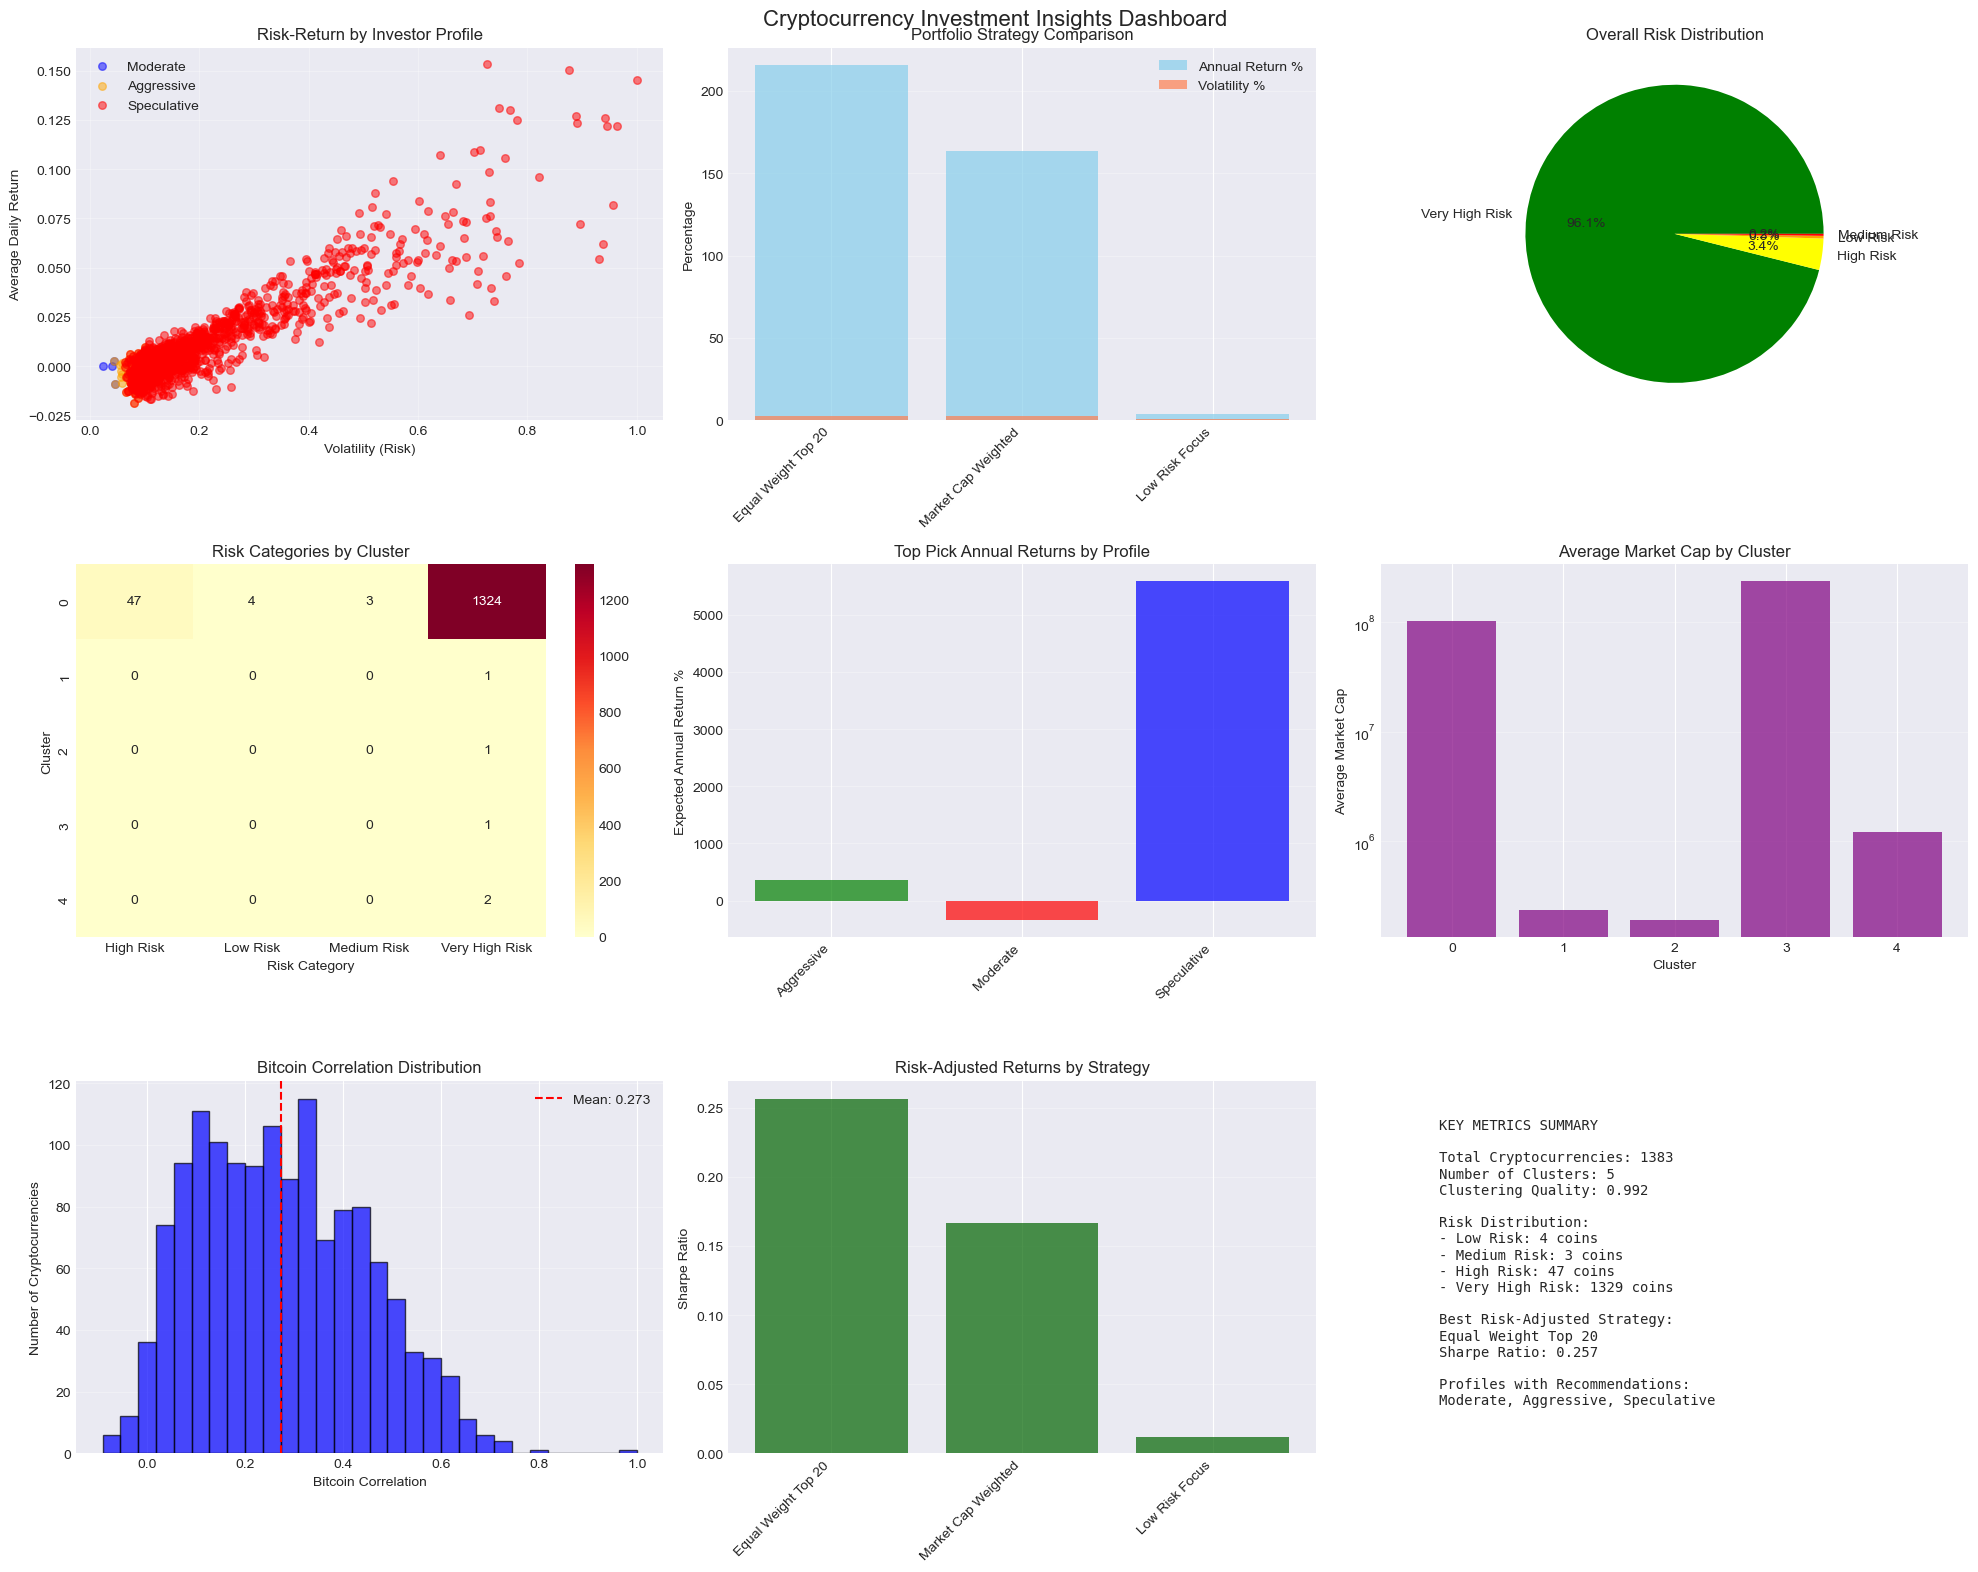

Investment insights dashboard saved to ../reports/investment_insights_dashboard.png


In [23]:
# Create comprehensive visual summary
fig = plt.figure(figsize=(20, 16))

# 1. Risk-Return Scatter by Investor Profile
ax1 = plt.subplot(3, 3, 1)
colors = ['green', 'blue', 'orange', 'red']
for i, (profile_name, rec) in enumerate(recommendations.items()):
    if rec['suitable_coins_count'] > 0:
        profile_coins = clustered_coins[
            (clustered_coins['volatility'] >= investor_profiles[profile_name]['preferred_volatility'][0]) & 
            (clustered_coins['volatility'] <= investor_profiles[profile_name]['preferred_volatility'][1])
        ]
        ax1.scatter(profile_coins['volatility'], profile_coins['avg_daily_return'], 
                   alpha=0.5, c=colors[i], label=profile_name, s=30)
ax1.set_xlabel('Volatility (Risk)')
ax1.set_ylabel('Average Daily Return')
ax1.set_title('Risk-Return by Investor Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Portfolio Strategy Comparison
ax2 = plt.subplot(3, 3, 2)
strategies = portfolio_comparison_df['Strategy']
returns = portfolio_comparison_df['expected_annual_return'] * 100
volatilities = portfolio_comparison_df['volatility'] * 100
ax2.bar(range(len(strategies)), returns, color='skyblue', alpha=0.7, label='Annual Return %')
ax2.bar(range(len(strategies)), volatilities, color='coral', alpha=0.7, label='Volatility %')
ax2.set_xticks(range(len(strategies)))
ax2.set_xticklabels(strategies, rotation=45, ha='right')
ax2.set_ylabel('Percentage')
ax2.set_title('Portfolio Strategy Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Risk Distribution Pie Chart
ax3 = plt.subplot(3, 3, 3)
risk_counts = clustered_coins['risk_category'].value_counts()
ax3.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
        colors=['green', 'yellow', 'orange', 'red'])
ax3.set_title('Overall Risk Distribution')

# 4. Cluster Risk Heatmap
ax4 = plt.subplot(3, 3, 4)
cluster_risk_matrix = clustered_coins.pivot_table(
    index='kmeans_cluster', 
    columns='risk_category', 
    values='name', 
    aggfunc='count', 
    fill_value=0
)
sns.heatmap(cluster_risk_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax4)
ax4.set_title('Risk Categories by Cluster')
ax4.set_xlabel('Risk Category')
ax4.set_ylabel('Cluster')

# 5. Top Coins by Profile - Fixed to handle empty recommendations
ax5 = plt.subplot(3, 3, 5)
profile_top_coins = {}
profiles_to_check = ['Conservative', 'Aggressive', 'Moderate', 'Speculative']

for profile in profiles_to_check:
    if (profile in recommendations and 
        len(recommendations[profile]['top_recommendations']) > 0):
        top_coin = recommendations[profile]['top_recommendations'][0]
        profile_top_coins[profile] = top_coin['avg_daily_return'] * 365 * 100

# Only plot if we have data
if profile_top_coins:
    ax5.bar(profile_top_coins.keys(), profile_top_coins.values(), 
            color=['green', 'red', 'blue', 'orange'][:len(profile_top_coins)], alpha=0.7)
    ax5.set_ylabel('Expected Annual Return %')
    ax5.set_title('Top Pick Annual Returns by Profile')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
else:
    ax5.text(0.5, 0.5, 'No recommendations\navailable for profiles', 
             ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Top Pick Annual Returns by Profile')

# 6. Market Cap Distribution by Cluster
ax6 = plt.subplot(3, 3, 6)
cluster_market_caps = clustered_coins.groupby('kmeans_cluster')['avg_market_cap'].mean()
ax6.bar(cluster_market_caps.index, cluster_market_caps.values, color='purple', alpha=0.7)
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Average Market Cap')
ax6.set_title('Average Market Cap by Cluster')
ax6.set_yscale('log')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Correlation with Bitcoin Distribution
ax7 = plt.subplot(3, 3, 7)
ax7.hist(clustered_coins['btc_correlation'], bins=30, color='blue', alpha=0.7, edgecolor='black')
ax7.axvline(clustered_coins['btc_correlation'].mean(), color='red', 
           linestyle='--', label=f"Mean: {clustered_coins['btc_correlation'].mean():.3f}")
ax7.set_xlabel('Bitcoin Correlation')
ax7.set_ylabel('Number of Cryptocurrencies')
ax7.set_title('Bitcoin Correlation Distribution')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# 8. Sharpe Ratio by Strategy
ax8 = plt.subplot(3, 3, 8)
sharpe_ratios = portfolio_comparison_df['sharpe_ratio']
ax8.bar(range(len(strategies)), sharpe_ratios, color='darkgreen', alpha=0.7)
ax8.set_xticks(range(len(strategies)))
ax8.set_xticklabels(strategies, rotation=45, ha='right')
ax8.set_ylabel('Sharpe Ratio')
ax8.set_title('Risk-Adjusted Returns by Strategy')
ax8.grid(True, alpha=0.3, axis='y')

# 9. Key Metrics Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""KEY METRICS SUMMARY

Total Cryptocurrencies: {len(clustered_coins)}
Number of Clusters: {clustering_metadata['n_clusters']}
Clustering Quality: {clustering_metadata['silhouette_score']:.3f}

Risk Distribution:
- Low Risk: {len(clustered_coins[clustered_coins['risk_category'] == 'Low Risk'])} coins
- Medium Risk: {len(clustered_coins[clustered_coins['risk_category'] == 'Medium Risk'])} coins
- High Risk: {len(clustered_coins[clustered_coins['risk_category'] == 'High Risk'])} coins
- Very High Risk: {len(clustered_coins[clustered_coins['risk_category'] == 'Very High Risk'])} coins

Best Risk-Adjusted Strategy:
{portfolio_comparison_df.loc[portfolio_comparison_df['sharpe_ratio'].idxmax(), 'Strategy']}
Sharpe Ratio: {portfolio_comparison_df['sharpe_ratio'].max():.3f}

Profiles with Recommendations:
{', '.join([p for p in recommendations.keys() if len(recommendations[p]['top_recommendations']) > 0])}
"""
ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, 
        fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.suptitle('Cryptocurrency Investment Insights Dashboard', fontsize=16)
plt.tight_layout()
plt.savefig('../reports/investment_insights_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Investment insights dashboard saved to ../reports/investment_insights_dashboard.png")

In [24]:
print("\n" + "=" * 80)
print("INVESTMENT INSIGHTS GENERATION COMPLETE")
print("=" * 80)
print("\nGenerated Files:")
print("1. clustering_insights.json - Comprehensive actionable insights")
print("2. investment_insights_dashboard.png - Visual summary dashboard")
print("\nKey Deliverables:")
print("- Investment recommendations for 4 investor profiles")
print("- Risk assessments for all cryptocurrencies and clusters")
print("- Portfolio diversification strategies")
print("- Market condition strategies")
print("- Risk management guidelines")
print("\nAll insights are based on historical data (2013-2018) and should be")
print("used for educational purposes only. Always conduct your own research.")
print("=" * 80)


INVESTMENT INSIGHTS GENERATION COMPLETE

Generated Files:
1. clustering_insights.json - Comprehensive actionable insights
2. investment_insights_dashboard.png - Visual summary dashboard

Key Deliverables:
- Investment recommendations for 4 investor profiles
- Risk assessments for all cryptocurrencies and clusters
- Portfolio diversification strategies
- Market condition strategies
- Risk management guidelines

All insights are based on historical data (2013-2018) and should be
used for educational purposes only. Always conduct your own research.
